Explorando el Impacto de la Defuzzificación: Centroide vs. Mean of Maxima en el Control del Camión
Implementación de robótica inteligente

Alumnos:
<br>Jonathan Arles Guevara Molina A01710380
<br>Ezzat Alzahouri Campos A01710709
<br>José Ángel Huerta Ríos A01710607
<br>Ricardo Sierra Roa A01709887

Equipo:
<br>Papuland

Profesor:
<br>Francisco Javier Navarro Barrón

Instituto Tecnológico y de Estudios Superiores de Monterrey
<br>Campus Querétaro

Fecha de entrega:
<br>14 de mayo de 2025


# *Nota: "Para Google Colab instalar de este forma las liberias"*

In [ ]:
!pip install -q numpy matplotlib plotly

In [ ]:
!pip install git+https://github.com/LUCIDresearch/JuzzyPython.git

  Cloning https://github.com/LUCIDresearch/JuzzyPython.git to /tmp/pip-req-build-qtcbpxwc
  Running command git clone --filter=blob:none --quiet https://github.com/LUCIDresearch/JuzzyPython.git /tmp/pip-req-build-qtcbpxwc
  Resolved https://github.com/LUCIDresearch/JuzzyPython.git to commit 1ac25f03fc574eadcf7ec4cb7bf0ef742e263ce6
  Preparing metadata (setup.py) ... done


# Truck Backer-Upper Control Problem
Estacionar en reversa un camión hacia un muelle de carga es un ejercicio difícil. Se trata de un problema de *control no lineal* para el cual métodos tradicionales de diseño de sistemas de control pueden encontrar dificultades.

## Consideraciones
1. La posición del camión está determinada exactamente por las tres variables de estado $ϕ$, $x$ e $y$, donde $ϕ$ es el ángulo del camión con la horizontal como se muestra en la figura.
2. El control del camión es el ángulo $θ$. Solo se considera el retroceso. El camión se mueve hacia atrás una distancia fija en cada etapa.
3. Por simplicidad, asumimos suficiente espacio entre el camión y el muelle de carga de modo que $y$ no tiene que ser considerado como una entrada.

El reto aquí es diseñar un sistema de control difuso cuyas entradas sean $ϕ \in [−90°, 270°]$ y $x \in [0,20]$, y cuya salida sea $\theta \in [−40°, 40°]$, de tal manera que los estados finales sean $(x_f ,\phi_f ) = (10,90°)$.

## Diagrama de la zona de carga simulada del camión
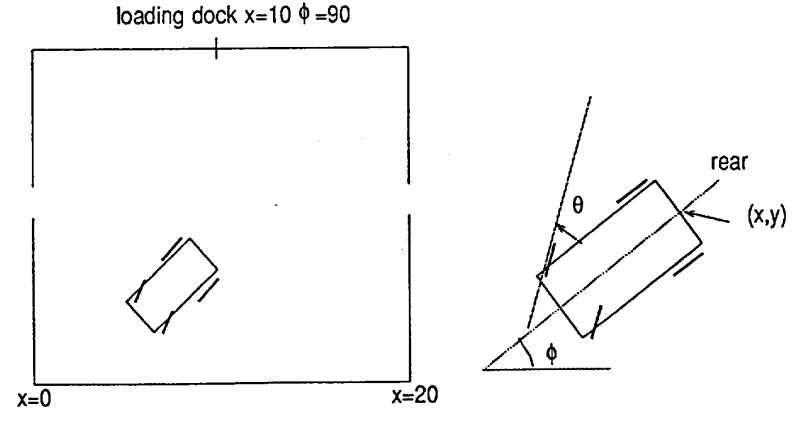

## Datos
Imagina que se le pidió a un conductor experimentado que nos ayudara a generar las mediciones de datos de entrada y salida "ideal", es decir, $(x,\phi,\theta)$ en diferentes estados $t$. De este modo, se recopilaron los siguientes datos con la trayectoria deseada comenzando desde $(x_0,\phi_0)=(1,0°)$

In [2]:
import numpy as np

# assume the data is ordered in the following order:
# ['t', 'x', 'phi', 'Theta']
data = np.array([[  0.  ,   1.  ,   0.  , -19.  ],
       [  1.  ,   1.95,   9.37, -17.95],
       [  2.  ,   2.88,  18.23, -16.9 ],
       [  3.  ,   3.79,  26.59, -15.85],
       [  4.  ,   4.65,  34.44, -14.8 ],
       [  5.  ,   5.45,  41.78, -13.75],
       [  6.  ,   6.18,  48.6 , -12.7 ],
       [  7.  ,   7.48,  54.91, -11.65],
       [  8.  ,   7.99,  60.71, -10.6 ],
       [  9.  ,   8.72,  65.99,  -9.55],
       [ 10.  ,   9.01,  70.75,  -8.5 ],
       [ 11.  ,   9.28,  74.98,  -7.45],
       [ 12.  ,   9.46,  78.7 ,  -6.4 ],
       [ 13.  ,   9.59,  81.9 ,  -5.34],
       [ 14.  ,   9.72,  84.57,  -4.3 ],
       [ 15.  ,   9.81,  86.72,  -3.25],
       [ 16.  ,   9.88,  88.34,  -2.2 ],
       [ 17.  ,   9.91,  89.44,   0.  ]])
data

array([[  0.  ,   1.  ,   0.  , -19.  ],
       [  1.  ,   1.95,   9.37, -17.95],
       [  2.  ,   2.88,  18.23, -16.9 ],
       [  3.  ,   3.79,  26.59, -15.85],
       [  4.  ,   4.65,  34.44, -14.8 ],
       [  5.  ,   5.45,  41.78, -13.75],
       [  6.  ,   6.18,  48.6 , -12.7 ],
       [  7.  ,   7.48,  54.91, -11.65],
       [  8.  ,   7.99,  60.71, -10.6 ],
       [  9.  ,   8.72,  65.99,  -9.55],
       [ 10.  ,   9.01,  70.75,  -8.5 ],
       [ 11.  ,   9.28,  74.98,  -7.45],
       [ 12.  ,   9.46,  78.7 ,  -6.4 ],
       [ 13.  ,   9.59,  81.9 ,  -5.34],
       [ 14.  ,   9.72,  84.57,  -4.3 ],
       [ 15.  ,   9.81,  86.72,  -3.25],
       [ 16.  ,   9.88,  88.34,  -2.2 ],
       [ 17.  ,   9.91,  89.44,   0.  ]])

### Consigna
En este Mini reto desarrollarán en equipo un Controlador Difuso el cual, dada la información proporcionada, genere las salidas que se aproximen a lo realizado por el conductor.

Puedes utilizar la estrategia de granulación que consideres pertinente así como los tipos de funciones de pertenencia que desees.

### Evaluación
Para medir el desempeño de tu sistema utilizarás la métrica RMSE (*Root Mean Squared Error*) definida como:

$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $

donde:
* $n$ es el número de puntos de datos.
* $y_i$ representa el valor real para el (i)-ésimo punto de datos.
* $\hat{y}_i$ representa el valor predicho para el (i)-ésimo punto de datos.

**Interpretación**: El RMSE mide la raíz cuadrada del promedio de los errores al cuadrado entre los valores reales y los valores predichos.
Cuanto menor sea el RMSE, mejor se ajustará el modelo a los datos observados.

In [3]:
def get_RMSE(real_values_list, predicted_value_list):
    return np.sqrt(np.square(np.subtract(real_values_list, predicted_value_list)).mean())

# Instalar librerias
pip install juzzyPy matplotlib, plotyly y np

# Librerias

In [4]:
from juzzyPython.generic.Input import Input
from juzzyPython.generic.Output import Output
from juzzyPython.type1.sets.T1MF_Triangular import T1MF_Triangular
from juzzyPython.generic.Plot import Plot
from juzzyPython.generic.Tuple import Tuple
from juzzyPython.type1.system.T1_Antecedent import T1_Antecedent
from juzzyPython.type1.system.T1_Consequent import T1_Consequent
from juzzyPython.type1.system.T1_Rule import T1_Rule
from juzzyPython.type1.system.T1_Rulebase import T1_Rulebase
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math

# Entradas y Salidas

In [5]:
# Entradas
x = Input("x", Tuple(0, 20))  # posición horizontal del camión
phi = Input("phi", Tuple(-90, 270)) # ángulo del camión

# Salida
theta = Output("theta", Tuple(-40, 40))  # ángulo de dirección

# FUNCIONES DE PERTENENCIA

In [6]:
#   ─── ENTRADAS ───────────────────────────────────────────────
# x
# Modificado (rangos superpuestos)
x_muy_bajo = T1MF_Triangular("muy_bajo", 0, 0, 5)
x_bajo = T1MF_Triangular("bajo", 0, 5, 10)
x_medio = T1MF_Triangular("medio", 5, 10, 15)
x_alto = T1MF_Triangular("alto", 10, 15, 20)
x_muy_alto = T1MF_Triangular("muy_alto", 15, 20, 20)

# φ
# Modificado (mejor solapamiento y cobertura)
phi_muy_neg = T1MF_Triangular("muy_neg", -90, -90, 0)
phi_neg = T1MF_Triangular("neg", -90, 0, 90)
phi_cero = T1MF_Triangular("cero", 0, 90, 180)
phi_pos = T1MF_Triangular("pos", 90, 180, 270)
phi_muy_pos = T1MF_Triangular("muy_pos", 180, 270, 270)

#   ─── SALIDA θ  (más granular) ───────────────────────────────
# Ajuste 2: Menos complejidad en la salida
theta_giro_max_izq = T1MF_Triangular("giro_max_izq", -40, -40, -20)
theta_giro_izq = T1MF_Triangular("giro_izq", -40, -20, 0)
theta_recto = T1MF_Triangular("recto", -10, 0, 10)
theta_giro_der = T1MF_Triangular("giro_der", 0, 20, 40)
theta_giro_max_der = T1MF_Triangular("giro_max_der", 20, 40, 40)

# Función para plotear las funciones de pertenencia

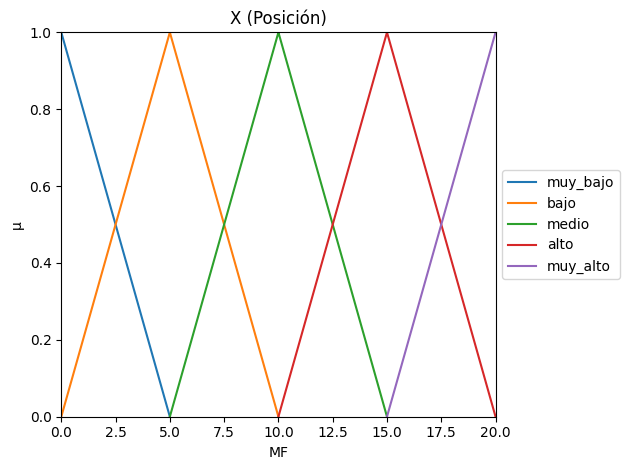

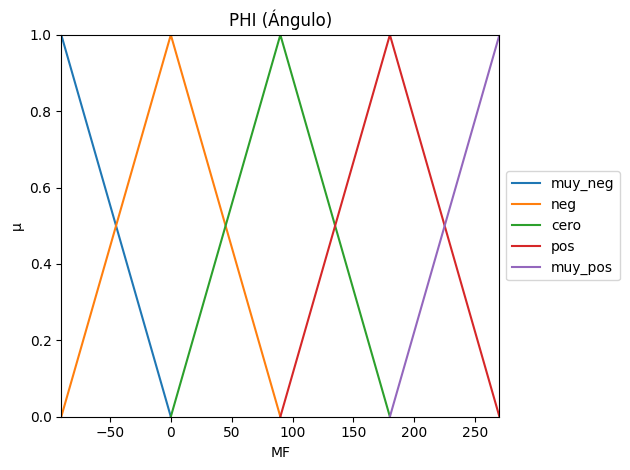

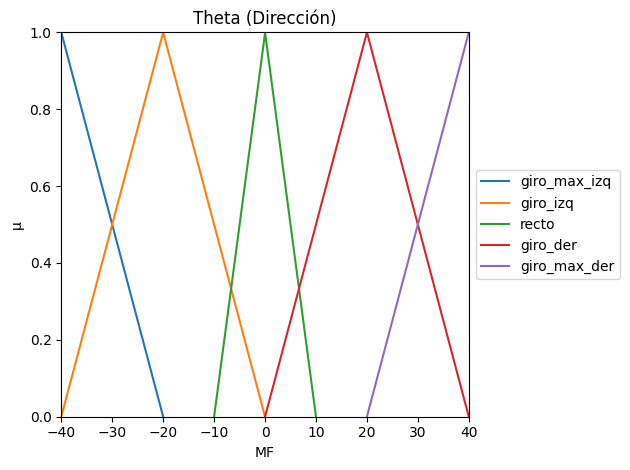

In [7]:
def plotMF(name, sets, xAxisRange, discretisationLevel):
    plot.figure()
    plot.title(name)
    for set in sets:
        plot.plotMF("MF",set.getName(),
                    set,
                    discretisationLevel,
                    xAxisRange,
                    Tuple(0, 1),
                    False)
        plot.legend()

plot = Plot()
# Crear las listas de funciones de membresía para cada variable
x_set = [x_muy_bajo, x_bajo, x_medio, x_alto, x_muy_alto]
phi_set = [phi_muy_neg, phi_neg, phi_cero, phi_pos, phi_muy_pos]
theta_set = [theta_giro_max_izq, theta_giro_izq, theta_recto, theta_giro_der, theta_giro_max_der]

# Graficar las funciones de membresía usando tu función personalizada
plotMF("X (Posición)", x_set, Tuple(0, 20), 1000)
plotMF("PHI (Ángulo)", phi_set, Tuple(-90, 270), 1000)
plotMF("Theta (Dirección)", theta_set, Tuple(-40, 40), 1000)

# Definición de Antecedentes y Consecuentes

In [8]:
# Definir los antecedentes (solo los que se utilizan en las reglas)
x_antecedent_muy_bajo = T1_Antecedent(x_muy_bajo, x, "x_muy_bajo")
x_antecedent_bajo = T1_Antecedent(x_bajo, x, "x_bajo")
x_antecedent_medio = T1_Antecedent(x_medio, x, "x_medio")
x_antecedent_alto = T1_Antecedent(x_alto, x, "x_alto")
x_antecedent_muy_alto = T1_Antecedent(x_muy_alto, x, "x_muy_alto")

phi_antecedent_muy_neg = T1_Antecedent(phi_muy_neg, phi, "phi_muy_neg")
phi_antecedent_neg = T1_Antecedent(phi_neg, phi, "phi_neg")
phi_antecedent_cero = T1_Antecedent(phi_cero, phi, "phi_cero")
phi_antecedent_muy_pos = T1_Antecedent(phi_muy_pos, phi, "phi_muy_pos")
phi_antecedent_pos = T1_Antecedent(phi_pos, phi, "phi_pos")

# Definir los consecuentes (solo los que se utilizan en las reglas)
theta_consequent_max_izq = T1_Consequent(theta_giro_max_izq, theta, "theta_max_izq")
theta_consequent_izq = T1_Consequent(theta_giro_izq, theta, "theta_izq")
theta_consequent_recto = T1_Consequent(theta_recto, theta, "theta_recto")
theta_consequent_der = T1_Consequent(theta_giro_der, theta, "theta_der")
theta_consequent_max_der = T1_Consequent(theta_giro_max_der, theta, "theta_max_der")


# REGLAS DIFUSAS

In [9]:
# Crear el rulebase (conjunto de reglas)
rulebase = T1_Rulebase()

# φ  Bajo
rulebase.addRule(T1_Rule([T1_Antecedent(x_muy_bajo, x, "x_muy_bajo"), T1_Antecedent(phi_muy_neg, phi, "phi_muy_neg")],theta_consequent_max_izq))
rulebase.addRule(T1_Rule([T1_Antecedent(x_bajo, x, "x_bajo"), T1_Antecedent(phi_neg, phi, "phi_neg")],theta_consequent_izq))
rulebase.addRule(T1_Rule([T1_Antecedent(x_bajo, x, "x_bajo"), T1_Antecedent(phi_muy_pos, phi, "phi_muy_pos")],theta_consequent_recto))

# φ  Medio
rulebase.addRule(T1_Rule([T1_Antecedent(x_medio, x, "x_medio"), T1_Antecedent(phi_cero, phi, "phi_cero")],theta_consequent_recto))
rulebase.addRule(T1_Rule([T1_Antecedent(x_medio, x, "x_medio"), T1_Antecedent(phi_muy_neg, phi, "phi_muy_neg")],theta_consequent_izq))
rulebase.addRule(T1_Rule([T1_Antecedent(x_medio, x, "x_medio"), T1_Antecedent(phi_muy_pos, phi, "phi_muy_pos")],theta_consequent_der))

# φ  Alto
rulebase.addRule(T1_Rule([T1_Antecedent(x_alto, x, "x_alto"), T1_Antecedent(phi_muy_neg, phi, "phi_muy_neg")],theta_consequent_recto))
rulebase.addRule(T1_Rule([T1_Antecedent(x_alto, x, "x_alto"), T1_Antecedent(phi_pos, phi, "phi_pos")],theta_consequent_der))
rulebase.addRule(T1_Rule([T1_Antecedent(x_muy_alto, x, "x_muy_alto"), T1_Antecedent(phi_muy_pos, phi, "phi_muy_pos")],theta_consequent_max_der))

# Mostrar el contenido del rulebase para ver que se ha creado correctamente
print(rulebase.toString())


Type-1 Fuzzy Logic System with 9 rules:
IF x_muy_bajo AND phi_muy_neg THEN theta_max_izq 
IF x_bajo AND phi_neg THEN theta_izq 
IF x_bajo AND phi_muy_pos THEN theta_recto 
IF x_medio AND phi_cero THEN theta_recto 
IF x_medio AND phi_muy_neg THEN theta_izq 
IF x_medio AND phi_muy_pos THEN theta_der 
IF x_alto AND phi_muy_neg THEN theta_recto 
IF x_alto AND phi_pos THEN theta_der 
IF x_muy_alto AND phi_muy_pos THEN theta_max_der 



# SISTEMA DE CONTROL Y SIMULACIÓN

In [10]:
# Método de desdifusificación (mejorado)
#Caso centroide RSME: 2.3968
#Caso Mean of Maximum RSME : 3.3494

# Función para procesar entradas y predecir theta
def processPredict(x_param, phi_param, method="centroid"):
    x.setInput(x_param)
    phi.setInput(phi_param)

    if method == "centroid":
        result = rulebase.evaluate(1) # Centroide
    elif method == "mom":
        result = rulebase.evaluate(0) # Mean of Maxima (MoM)
    else:
        print("Método de desdifusificación no es válido. Se usará centroide por defecto.")
        result = rulebase.evaluate(1)  # Centroide

    return result[theta]

In [11]:
# Generar las predicciones de theta usando los datos reales
predict_aux = 0.0

# Centroide
predicted_theta_centroide = []
for i in data:
    predict_aux= processPredict(i[1], i[2], "centroid")
    predicted_theta_centroide.append(predict_aux)

# MoM
predicted_theta_mom = []
for i in data:
    predict_aux= processPredict(i[1], i[2], "mom")
    predicted_theta_mom.append(predict_aux)

# CALCULAR RMSE (PRECISIÓN)

In [12]:
true_theta = data[:, 3]
rmse = get_RMSE(true_theta, predicted_theta_centroide)
print(f'RMSE del sistema difuso - centroide: {rmse:.4f}')
rmse = get_RMSE(true_theta, predicted_theta_mom)
print(f'RMSE del sistema difuso - mom: {rmse:.4f}')

RMSE del sistema difuso - centroide: 2.3968
RMSE del sistema difuso - mom: 3.3494


# MOSTRAR TABLA DE RESULTADOS

In [13]:
import pandas as pd

resultados = pd.DataFrame({
    'x': data[:, 1],
    'phi': data[:, 2],
    'theta real': true_theta,
    'theta predicho - Centroide': predicted_theta_centroide,
    'theta predicho - MOM': predicted_theta_mom
})

print(resultados)

       x    phi  theta real  theta predicho - Centroide  theta predicho - MOM
0   1.00   0.00      -19.00                  -19.995877            -20.000000
1   1.95   9.37      -17.95                  -19.991897            -20.000000
2   2.88  18.23      -16.90                  -19.995023            -20.000000
3   3.79  26.59      -15.85                  -19.994556            -20.000000
4   4.65  34.44      -14.80                  -19.995053            -20.000000
5   5.45  41.78      -13.75                  -18.624788            -17.123580
6   6.18  48.60      -12.70                  -16.354202            -13.218391
7   7.48  54.91      -11.65                  -13.178764             -8.802207
8   7.99  60.71      -10.60                  -11.852391             -7.048490
9   8.72  65.99       -9.55                  -10.205565             -5.175783
10  9.01  70.75       -8.50                   -8.839578             -4.023936
11  9.28  74.98       -7.45                   -7.234363         

# Comparación de datos en Gráfica

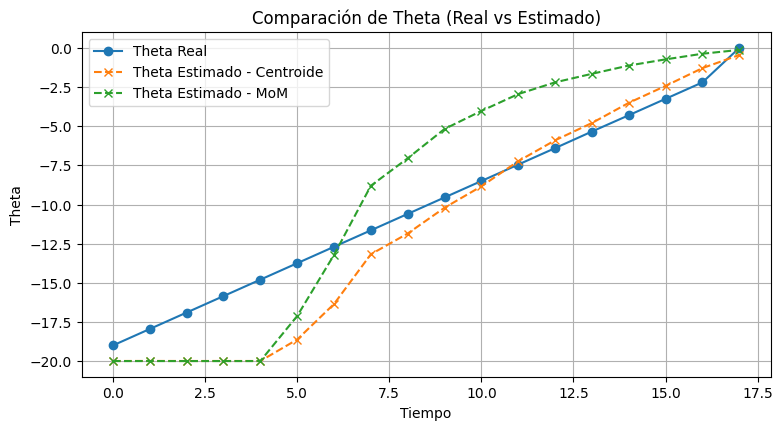

In [14]:
# Extrayendo los datos
t = data[:, 0]
x_real = data[:, 1]
phi_real = data[:, 2]
theta_real = data[:, 3]
theta_est_centroide = predicted_theta_centroide  # Los valores estimados - centroide
theta_est_mom = predicted_theta_mom  # Los valores estimados - mom

# Crear la figura y los ejes
plt.figure(figsize=(15, 8))

# Gráfica para Theta (Real vs Estimado)
plt.subplot(2, 2, 3)
plt.plot(t, theta_real, label='Theta Real', linestyle='-', marker='o')
plt.plot(t, theta_est_centroide, label='Theta Estimado - Centroide', linestyle='--', marker='x')
plt.plot(t, theta_est_mom, label='Theta Estimado - MoM', linestyle='--', marker='x')
plt.title('Comparación de Theta (Real vs Estimado)')
plt.xlabel('Tiempo')
plt.ylabel('Theta')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Surface view con Plotly

In [15]:
def surfaceView(useCentroid, input1Disc, input2Disc, title="Surface View"):
    # Definir las resoluciones para las entradas (discretización)
    incrX = (x.getDomain().getRight() - x.getDomain().getLeft()) / (input1Disc - 1.0)
    incrY = (phi.getDomain().getRight() - phi.getDomain().getLeft()) / (input2Disc - 1.0)

    # Crear listas para los ejes x, y, z
    x_vals, phi_vals, z_vals = [], [], [[0] * input1Disc for _ in range(input2Disc)]

    # Generar los valores de x y phi según la discretización
    for i in range(input1Disc):
        x_vals.append(x.getDomain().getLeft() + i * incrX)
    for i in range(input2Disc):
        phi_vals.append(phi.getDomain().getLeft() + i * incrY)

    # Calcular los valores de salida (Z) para cada combinación de x y phi
    for x_ in range(input1Disc):
        x.setInput(x_vals[x_])
        for y_ in range(input2Disc):
            phi.setInput(phi_vals[y_])

            # Evaluar el sistema difuso según el método seleccionado
            if useCentroid:
                out = rulebase.evaluate(1)[theta]  # Centroide
            else:
                out = rulebase.evaluate(0)[theta]  # MoM

            # Verificar que el resultado no sea None o NaN
            if out is None or math.isnan(out):
                out = 0.0  # Asignar 0 si es None o NaN

            z_vals[y_][x_] = out  # Almacenar el resultado en la matriz Z

    # Crear gráfico de superficie con Plotly
    fig = go.Figure(data=[go.Surface(z=z_vals, x=x_vals, y=phi_vals)])
    fig.update_layout(
        title=title,
        scene=dict(
            xaxis_title='x (Posición)',
            yaxis_title='phi (Ángulo)',
            zaxis_title='theta (Dirección)'
        ),
        autosize=True,
        width=700,
        height=500,
        margin=dict(l=30, r=30, b=50, t=30)
    )
    fig.show()

# Llamada a la función
surfaceView(True, 100, 100, "Superficie de Control - Centroide")
surfaceView(False, 100, 100, "Superficie de Control - MoM")


# Análisis de Superficies de Control (Notebook: Impacto de la Defuzzificación)

## Comparación de métodos: SOM, LOM, MOM, Centroid

### Suavidad
- **Centroid**: genera superficies **suaves y continuas**, ideales para un control estable.
- **SOM** y **LOM**: presentan superficies **con discontinuidades** (saltos), lo que puede traducirse en comportamientos bruscos.
- **MOM**: ofrece una **suavidad intermedia**, con cierta continuidad pero sin la precisión del centroide.

### Rango de salida
- **LOM**: favorece los valores **más altos** dentro de los máximos posibles, extendiendo el rango superior.
- **SOM**: selecciona los valores **más bajos** dentro del conjunto óptimo.
- **MOM** y **Centroid**: tienden a mantener los valores dentro de una **zona intermedia**, más balanceada.

### Implicaciones en el control del camión
- **SOM**: Da lugar a un comportamiento **más conservador**; útil para reducir riesgos, como evitar giros bruscos o aceleraciones innecesarias.
- **LOM**: Puede resultar en decisiones **más agresivas**, como giros amplios o rápidas aceleraciones si se considera "óptimo".
- **Centroid**: Ofrece el **control más estable** porque se suele utilizar en implementaciones parecidas a navegación continua o control de precisión.
- **MOM**: Representa un **balance entre simplicidad computacional y estabilidad**, útil si no se cuenta con muchos recursos de cálculo.

---

# Métodos de Defuzzificación: SOM y LOM

## Smallest of Maxima (SOM)
- **Definición**: Selecciona el menor valor de entrada (x) que tiene el valor máximo de pertenencia en la función de salida difusa.
- **Ventaja**: Conservador. Útil cuando es preferible elegir la opción más baja posible dentro de las mejores (máximas).
- **Ejemplo de uso**: Sistemas donde se desea minimizar riesgos o costos (por ejemplo, establecer la velocidad mínima segura de un coche autónomo en condiciones riesgosas).

## Largest of Maxima (LOM)
- **Definición**: Selecciona el mayor valor de entrada (x) que tiene el valor máximo de pertenencia.
- **Ventaja**: Agresivo. Se elige la opción más alta posible dentro del conjunto óptimo.
- **Ejemplo de uso**: Casos donde conviene ser más optimista o ambicioso, como fijar el mayor nivel de inversión recomendado si varios niveles son igualmente "óptimos".

---

# Comparación de Métodos según el Escenario

| Escenario                                                                                      | Método recomendado | Justificación                                                                 |
|-----------------------------------------------------------------------------------------------|--------------------|-------------------------------------------------------------------------------|
| Sistemas con alta prioridad en **seguridad** o **conservadurismo** (p.ej. médicos, frenado)   | SOM                | Elige el menor valor dentro de los óptimos → más precaución.                 |
| Sistemas donde se desea **maximizar eficiencia** o **tomar riesgos calculados**               | LOM                | Elige el mayor valor dentro de los óptimos → mayor ambición.                 |
| Sistemas que necesitan **precisión física o realista**, como brazos robóticos                 | COG (Centroid)     | Representa mejor el "promedio real" del resultado difuso.                    |
| Sistemas con salidas **simétricas** o múltiples valores máximos sin preferencia por extremos | MOM                | Balancea entre extremos sin tomar partido.                                   |


# Reflexión Final: Cuándo usar SOM y LOM frente a Centroid y MOM

Los métodos de defuzzificación **SOM (Smallest of Maxima)** y **LOM (Largest of Maxima)**, aunque menos suaves y precisos que el **centroide** o el **MOM (Mean of Maxima)**, tienen aplicaciones relevantes en escenarios donde el control debe tomar decisiones **rápidas y extremas**.

**SOM** es ideal cuando el sistema necesita adoptar una postura **conservadora o segura**, como en sistemas críticos de seguridad (e.g. frenos de emergencia, atención médica automatizada). Su tendencia a elegir el valor más bajo entre los máximos permite actuar con mayor **precaución**, evitando riesgos innecesarios.

**LOM**, por otro lado, favorece decisiones **ambiciosas y proactivas**, siendo útil en contextos donde **maximizar el rendimiento** es prioritario y el riesgo es tolerable (e.g. estrategias de inversión automatizadas, sistemas de promoción dinámicos).

A diferencia de estos, el método del **centroide (COG)** es el más adecuado cuando se requiere un control **continuo, suave y equilibrado**, como en brazos robóticos o navegación autónoma. Mientras tanto, **MOM** puede servir como una alternativa razonable cuando no hay una preferencia clara entre extremos y se busca simplicidad computacional.

En resumen, SOM y LOM aportan valor al permitir una **toma de decisiones más directa y extrema**, lo cual puede ser una **ventaja táctica** en ciertos contextos, a pesar de su menor precisión global.


# Bibliografía


Himanshu., S., Yunis., A. (2020). "*Deep Neuro-Fuzzy Systems with Python*". APRESS. Recuperado de https://tecmx-my.sharepoint.com/personal/fj_navarro_barron_tec_mx/_layouts/15/onedrive.aspx?id=%2Fpersonal%2Ffj%5Fnavarro%5Fbarron%5Ftec%5Fmx%2FDocuments%2FBooks%2FFuzzy%20Control%2Fdeep%2Dneuro%2Dfuzzy%2Dsystems%2Dwith%2Dpython%2Dwith%2Dcase%2Dstudies%2Dand%2Dapplications%2Dfrom%2Dthe%2Dindustry%2D1st%2Ded%2D978%2D1%2D4842%2D5360%2D1%2D978%2D1%2D4842%2D5361%2D8%5Fcompress%2Epdf&parent=%2Fpersonal%2Ffj%5Fnavarro%5Fbarron%5Ftec%5Fmx%2FDocuments%2FBooks%2FFuzzy%20Control&ga=1

MathWorks. (2025). "*Defuzzification Methods*". MathWorks. Recuperado de: [https://www.mathworks.com/help/fuzzy/defuzzification-methods.html](https://www.mathworks.com/help/fuzzy/defuzzification-methods.html)

Samanta, D. (s.f.). "*Defuzzification Methods*" (Capítulo 5). Indian Institute of Technology Kharagpur. Recuperado de: [https://cse.iitkgp.ac.in/~dsamanta/courses/archive/sca/Archives/Chapter%205%20Defuzzification%20Methods.pdf](https://cse.iitkgp.ac.in/~dsamanta/courses/archive/sca/Archives/Chapter%205%20Defuzzification%20Methods.pdf)
